In [ ]:
# ---------------------------------------------------------------------------------#

#                         Machine Learning for Cybersecurity                                 #
#              Group Project: Automatic License Plate Detection                      #
#                                          and recognition                                                #

#            Team Members: Blake Downey, Kai Luo, John Villanueva                #

# ---------------------------------------------------------------------------------#

In [ ]:
from tensorflow.python.client import device_lib
import tensorflow as tf

print(device_lib.list_local_devices())

print('num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
#print(sess)

## Imports

In [1]:
import cv2
import os
import numpy as np
from imutils import paths
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import Sequential, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import RootMeanSquaredError as rmse
from tensorflow.keras.losses import MeanSquaredError as MSE_loss
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts
from tensorflow.keras.optimizers import Adam, SGD

## Image name and LP breakdown

In [2]:
'''
Image Title Description:
Area-Tilt degree-Bounding box coordinates-Four vertices locations-License plate number-Brightness-Blurriness
'''

# License Plate index reference
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

## Example loading data and splicing name

In [9]:
def example_loader():
    #dataset location
    LOC = 'D:/UW/CCPD2019/CCPD2019/ccpd_base/'

    #image paths
    image_paths = list(paths.list_images(LOC))

    #print example path
    print(image_paths[0])

    num = 3534

    #load example image
    test_image = img_to_array(load_img(image_paths[num], color_mode='grayscale'))
    cropped_image = test_image[226:674,126:574]
    print(cropped_image.dtype)

    # get the base name of the file, split on '.' to remove extension
    test_base = os.path.splitext(os.path.basename(image_paths[num]))[0]

    # split on '-' to separate information
    test_base_split = test_base.split('-')
    
    LP = []
    LP_chars = test_base_split[4].split('_')
    print(f'LP_chars: {LP_chars}')
    LP.append(provinces[int(LP_chars[0])])
    LP.append(alphabets[int(LP_chars[1])])
    for i in range(2,len(LP_chars)):
        LP.append(ads[int(LP_chars[i])])

    print('Example image name and breakdown: \nName: ', test_base)
    print(f'\nArea: {test_base_split[0]}')
    print(f'Tilt degree: {test_base_split[1]}')
    print(f'Bounding Box Coordinates: {test_base_split[2]}')
    print(f'Four Vertices Locations: {test_base_split[3]}')
    print(f'License Plate Number: {LP}')
    print(f'Brightness: {test_base_split[5]}')
    print(f'Blurriness: {test_base_split[5]}')

    test_corners = test_base_split[2].split('_')
    test_BB = [x.split('&') for x in test_corners]

    # show example image
    plt.figure(figsize=(20,10))
    plt.imshow(test_image,cmap='gray')
    plt.plot(int(test_BB[0][0]), int(test_BB[0][1]), marker='o', markersize=7, markerfacecolor="yellow")
    plt.plot(int(test_BB[1][0]), int(test_BB[1][1]), marker='o', markersize=7, markerfacecolor="green")
    plt.show()
    plt.imshow(cropped_image,cmap='gray')
    plt.plot(int(test_BB[0][0])-126, int(test_BB[0][1])-226, marker='o', markersize=7, markerfacecolor="yellow")
    plt.plot(int(test_BB[1][0])-126, int(test_BB[1][1])-226, marker='o', markersize=7, markerfacecolor="green")
    plt.show()

    print(f'shape of cropped image: {cropped_image.shape}')

D:/UW/CCPD2019/CCPD2019/ccpd_base/00205459770115-90_85-352&516_448&547-444&547_368&549_364&517_440&515-0_0_22_10_26_29_24-128-7.jpg
float32
LP_chars: ['0', '0', '11', '28', '27', '27', '30']
Example image name and breakdown: 
Name:  00662715517241-88_95-319&501_455&556-448&545_321&556_321&512_448&501-0_0_11_28_27_27_30-129-16

Area: 00662715517241
Tilt degree: 88_95
Bounding Box Coordinates: 319&501_455&556
Four Vertices Locations: 448&545_321&556_321&512_448&501
License Plate Number: ['皖', 'A', 'M', '4', '3', '3', '6']
Brightness: 129
Blurriness: 129


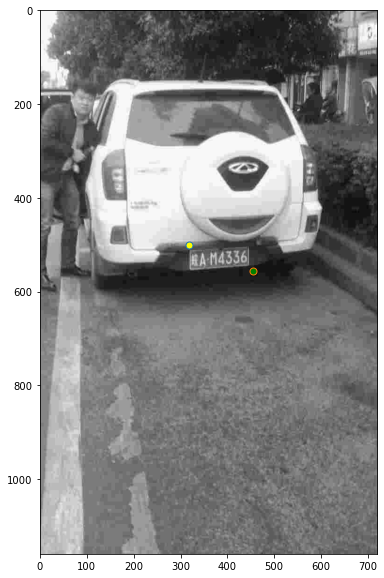

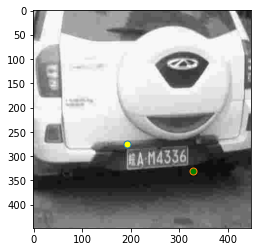

shape of cropped image: (448, 448, 1)


In [10]:
example_loader()

## Load Bounding Box and Image Path Data

In [2]:
#dataset location
LOC = 'D:/UW/CCPD2019/CCPD2019/ccpd_base/'
# image paths
image_paths = list(paths.list_images(LOC))
total_ims = 50000
image_paths_sample = image_paths[:total_ims]

# Bounding Box locations (BB_loc)
BB_loc = []

for path in image_paths_sample:
    base = os.path.splitext(os.path.basename(path))[0].split('-')
    corners = base[2].split('_')
    BB = [x.split('&') for x in corners]
    # convert to int and account for cropped image dimensions
    BB[0] = list(map(int,BB[0])) # convert to int
    BB[0][0] = BB[0][0]-126
    BB[0][1] = BB[0][1]-226
    # convert to int and account for cropped image dimensions
    BB[1] = list(map(int,BB[1])) # convert to int
    BB[1][0] = BB[1][0]-126
    BB[1][1] = BB[1][1]-226

    BB_loc.append(BB)
    
BB_loc = np.asarray(BB_loc)
BB_loc = np.reshape(BB_loc, (total_ims, 1,4))
print(f'Bounding Box Array Dims: {BB_loc.shape}')
print(f'Length of Sample Image Paths: {len(image_paths_sample)}')
print(f'Sample y value (un-normalized): {BB_loc[0]}')
BB_loc = BB_loc / 448 # normalize
print(f'Sample y value (normalized): {BB_loc[0]}')

print('All Data Loaded!')

Bounding Box Array Dims: (50000, 1, 4)
Length of Sample Image Paths: 50000
Sample y value (un-normalized): [[226 290 322 321]]
Sample y value (normalized): [[0.50446429 0.64732143 0.71875    0.71651786]]
All Data Loaded!


## Define Model

In [3]:
def build_model():
    # The input shape of the model is (*, 448, 448, 1)
    model = Sequential()
    model.add(layers.MaxPool2D()) #MaxPooling2D-> (*, 224, 224, 10)
    
    # (*, 448, 448, 1) -Conv2D+ReLU-> (*, 448, 448, 10) 
    model.add(layers.Conv2D(10, 3, activation='relu', padding='same', input_shape=(448, 448, 1)))
    model.add(layers.MaxPool2D()) #MaxPooling2D-> (*, 224, 224, 10)

    model.add(layers.Dropout(0.5))
    
    # (*, 224, 224, 10) -Conv2D+ReLU-> (*, 224, 224, 40)
    model.add(layers.Conv2D(40, 3, activation='relu', padding='same', activity_regularizer=l2(0.01)))
    model.add(layers.MaxPool2D()) #MaxPooling2D-> (*, 112, 112, 40)
    
    model.add(layers.Dropout(rate=0.5))
    
    # (*, 112, 112, 40) -Conv2D+ReLU-> (*, 112, 112, 100)
    model.add(layers.Conv2D(200, 3, activation='relu', padding='same', activity_regularizer=l2(0.01)))
    model.add(layers.MaxPool2D()) #MaxPooling2D-> (*, 56, 56, 100)

    model.add(layers.Dropout(rate=0.5))
    
    # (*, 56, 56, 100) -Conv2D+ReLU-> (*, 14, 14, 800)
    model.add(layers.Conv2D(800, 4, activation='relu', strides=(4,4), activity_regularizer=l2(0.01)))
    model.add(layers.MaxPool2D()) #MaxPooling2D-> (*, 7, 7, 800)
    
    # (*, 7, 7, 800) -Conv2D-> (*, 5, 5, 800)
    model.add(layers.Conv2D(800, 3))  
    model.add(layers.Flatten()) # (*, 1, 20000)
    
    # (*, 20000) -Conv2D-> (*, 4)
    model.add(layers.Dense(4)) 
    
    # Build SGD optimizer and MSE loss
    sgd = SGD(learning_rate=0.1, momentum=0.9)
    model.compile(loss=MSE_loss(), optimizer='adam', metrics=['accuracy', MSE_loss()])
    
    return model

In [4]:
X_train, X_val, y_train, y_val = tts(image_paths_sample, BB_loc, test_size=0.1)
print(len(X_train))
print(len(y_train))

45000
45000


In [5]:
batch_size = 500
train_images = []

model = build_model()
count = 0
for i in range(0, len(X_train), batch_size):
    count += 1
    if count > 2: break
    train_images = []
    print("loading batch of images...")
    for j in range(i, i + batch_size):
        temp_im = img_to_array(load_img(X_train[j], color_mode='grayscale'))
        train_images.append(temp_im[226:674,126:574])
    train_images = np.asarray(train_images)
    print(f'images loaded in RAM: {train_images.shape}')
    train_labels = y_train[i:i+batch_size]
    print(f'Training on batch: {int(i/batch_size) + 1} / 45')
    model.fit(train_images, train_labels, batch_size=8, epochs=3)
    
model.save("./models/V1R6.h5")

loading batch of images...
images loaded in RAM: (500, 448, 448, 1)
Training on batch: 1 / 45
Epoch 1/3
63/63 [==============================] - 30s 251ms/step - loss: 537972.2500 - accuracy: 0.3991 - mean_squared_error: 84.0710
Epoch 2/3
63/63 [==============================] - 15s 236ms/step - loss: 1136.3838 - accuracy: 0.5226 - mean_squared_error: 0.1521
Epoch 3/3
63/63 [==============================] - 15s 245ms/step - loss: 172.0647 - accuracy: 0.5306 - mean_squared_error: 0.0268
loading batch of images...
images loaded in RAM: (500, 448, 448, 1)
Training on batch: 2 / 45
Epoch 1/3
63/63 [==============================] - 14s 229ms/step - loss: 120.6348 - accuracy: 0.5228 - mean_squared_error: 0.0264
Epoch 2/3
63/63 [==============================] - 15s 234ms/step - loss: 96.5340 - accuracy: 0.5226 - mean_squared_error: 0.0245
Epoch 3/3
63/63 [==============================] - 16s 246ms/step - loss: 78.0162 - accuracy: 0.5216 - mean_squared_error: 0.0243


In [6]:
val_images = []
val_labels = []

print("loading validation images...")
for i in range(200):
    temp_im = img_to_array(load_img(X_val[i], color_mode='grayscale'))
    val_images.append(temp_im[226:674,126:574])
val_images = np.asarray(val_images)
val_labels = y_val[:200]
print(f'validation images loaded in RAM: {val_images.shape}')
print('predicting BB locations...', end='')
pred_val = model.predict(val_images)
print('completed')

loading validation images...
validation images loaded in RAM: (200, 448, 448, 1)
predicting BB locations...completed


[[ 94. 288. 276. 370.]]
[148.22714 256.66968 339.21396 322.5276 ]


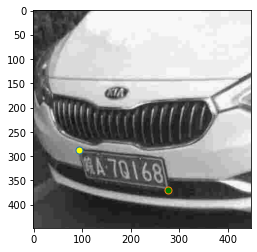

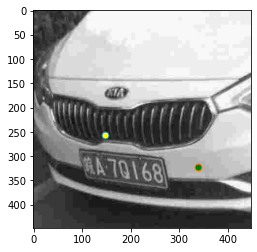

In [7]:
im_num = 58

print(val_labels[im_num]*448)
print(pred_val[im_num]*448)



plt.imshow(val_images[im_num],cmap='gray')
plt.plot(int(val_labels[im_num][0][0]*448), int(val_labels[im_num][0][1]*448), marker='o', markersize=7, markerfacecolor="yellow")
plt.plot(int(val_labels[im_num][0][2]*448), int(val_labels[im_num][0][3]*448), marker='o', markersize=7, markerfacecolor="green")
plt.show()
plt.imshow(val_images[im_num],cmap='gray')
plt.plot(int(pred_val[im_num][0]*448), int(pred_val[im_num][1]*448), marker='o', markersize=7, markerfacecolor="yellow")
plt.plot(int(pred_val[im_num][2]*448), int(pred_val[im_num][3]*448), marker='o', markersize=7, markerfacecolor="green")
plt.show()

In [8]:
print(pred_val*448)

print()


for i,true in enumerate(val_labels):
    if true[0][0]*448 < pred_val[0][0]*448 + 1 and true[0][0]*448 > pred_val[0][0]*448 - 1:
        print(i)
    

[[148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.2301  256.67108 339.2134  322.5282 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.2286  256.6714  339.21588 322.5295 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22754 256.67004 339.21432 322.52805]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714 256.66968 339.21396 322.5276 ]
 [148.22714